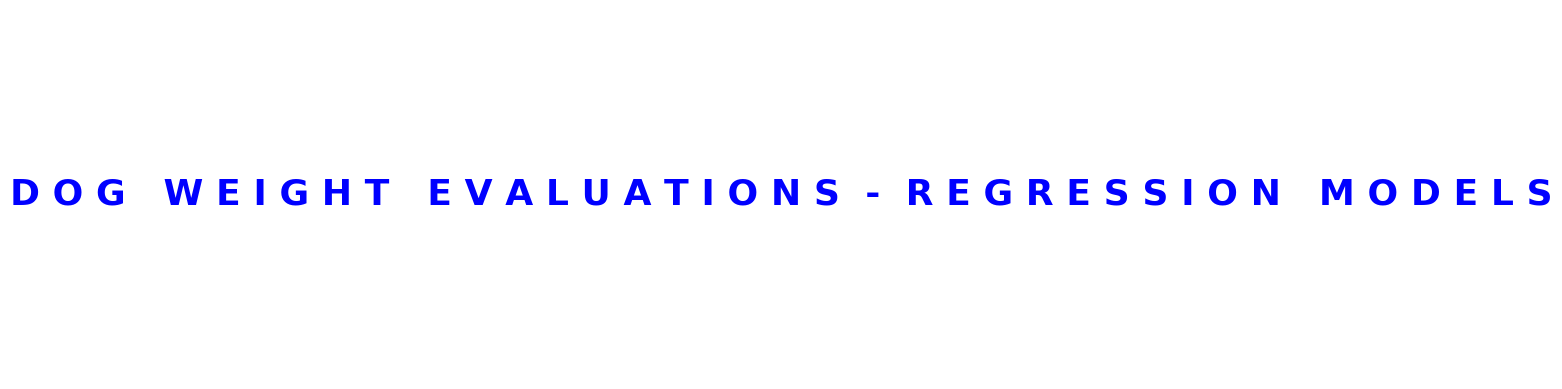

The recommended model based on the composite score is: Gradient Boosting


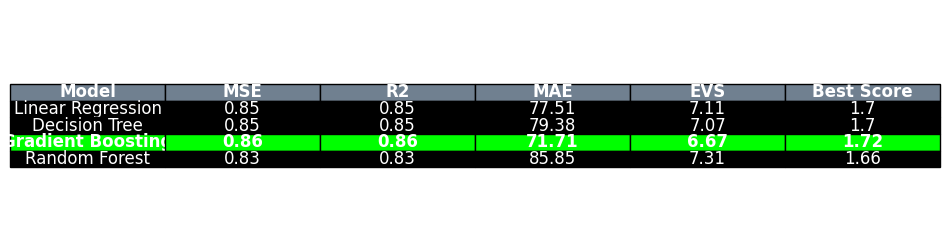

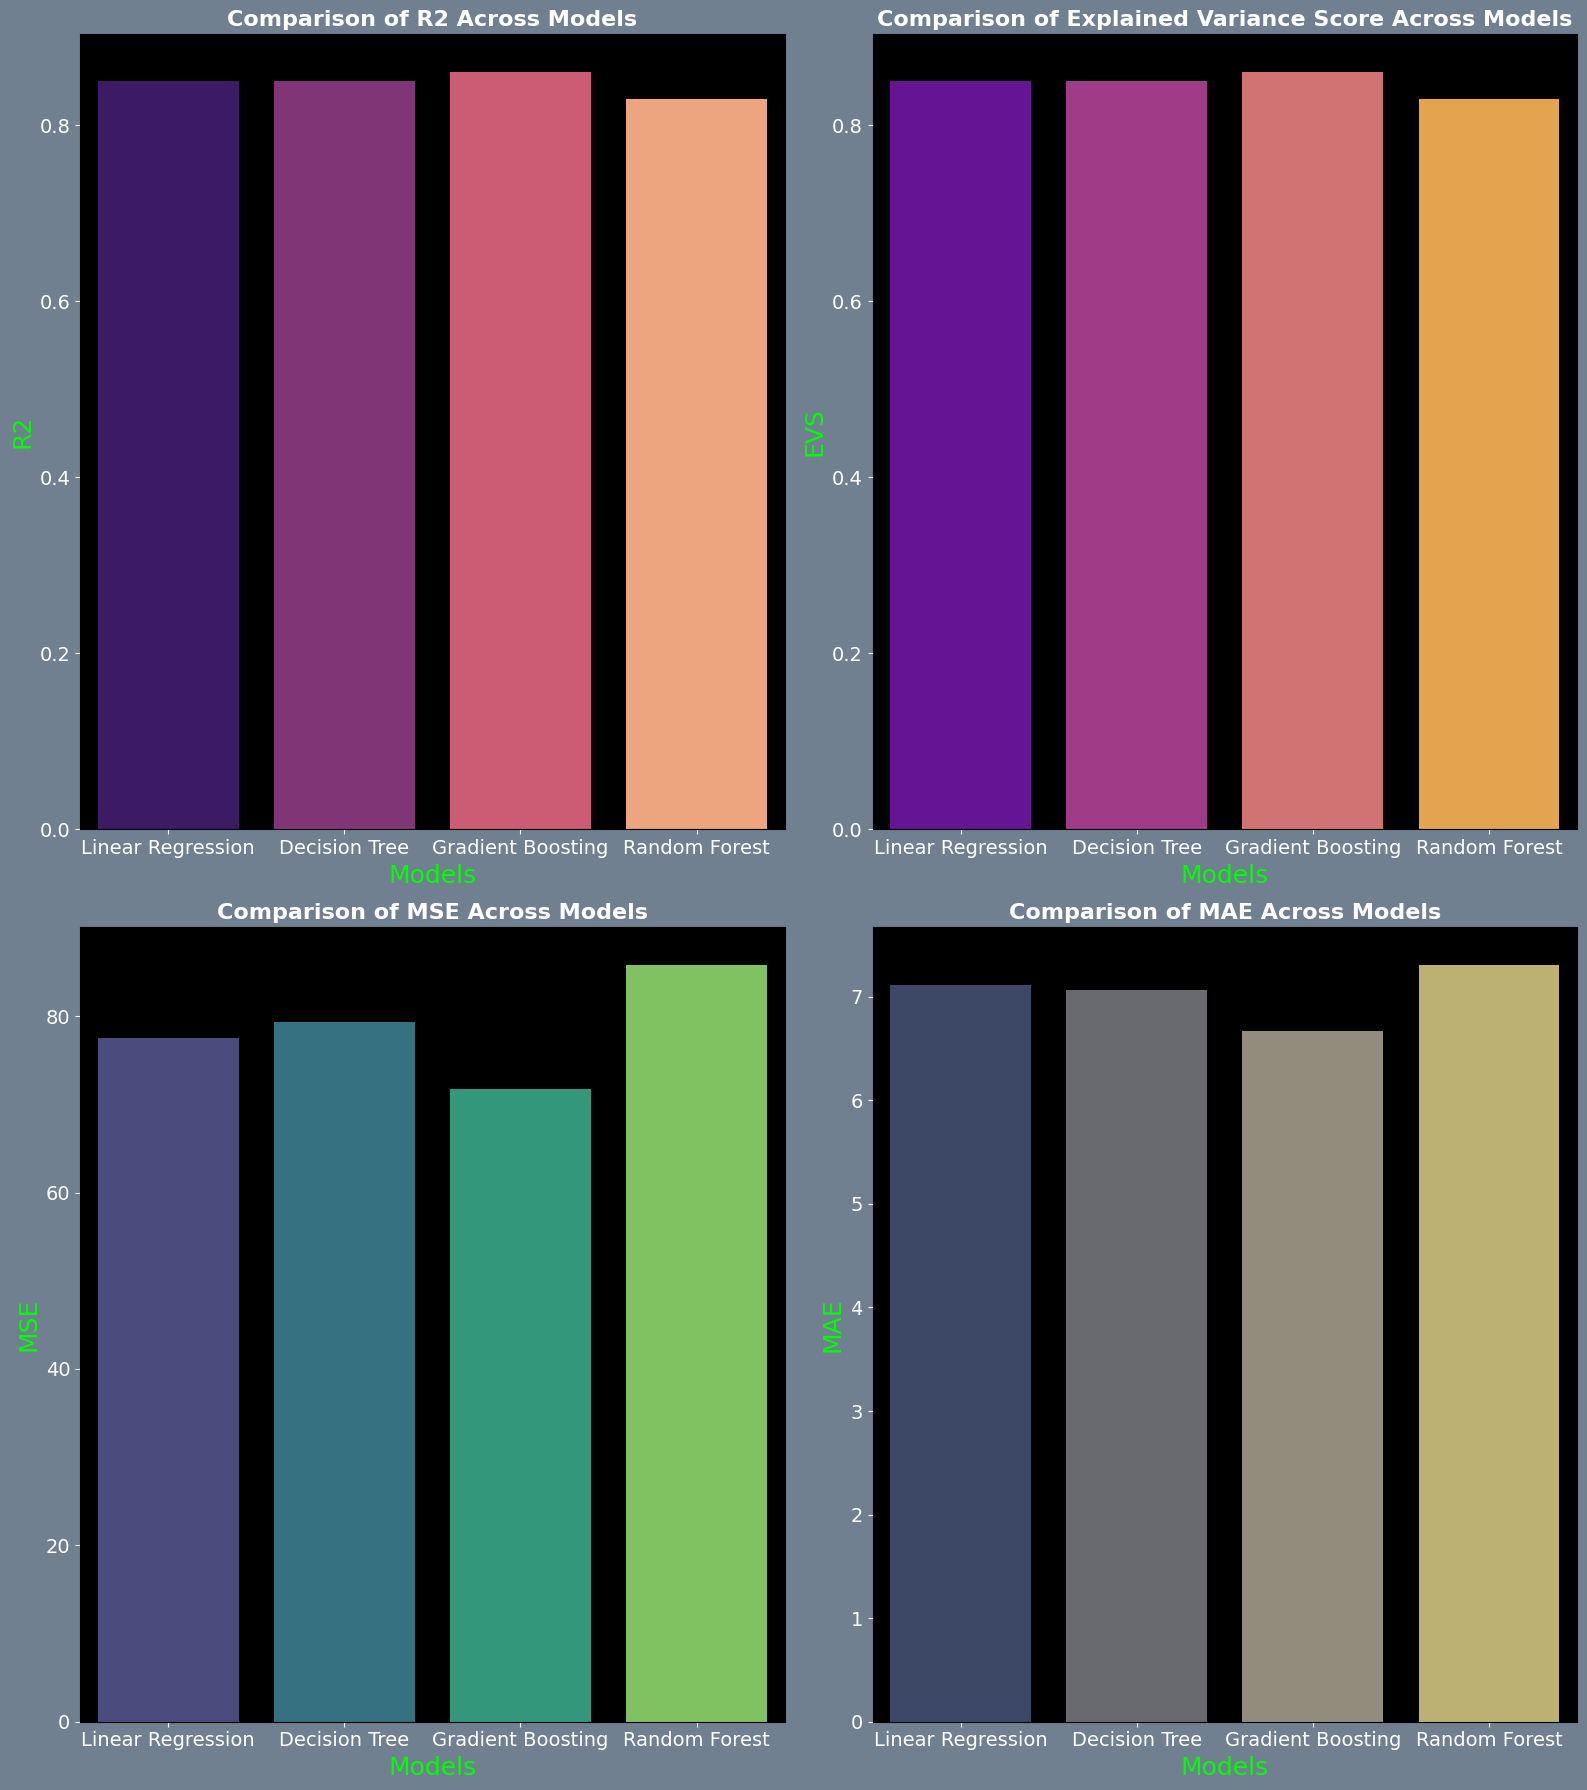

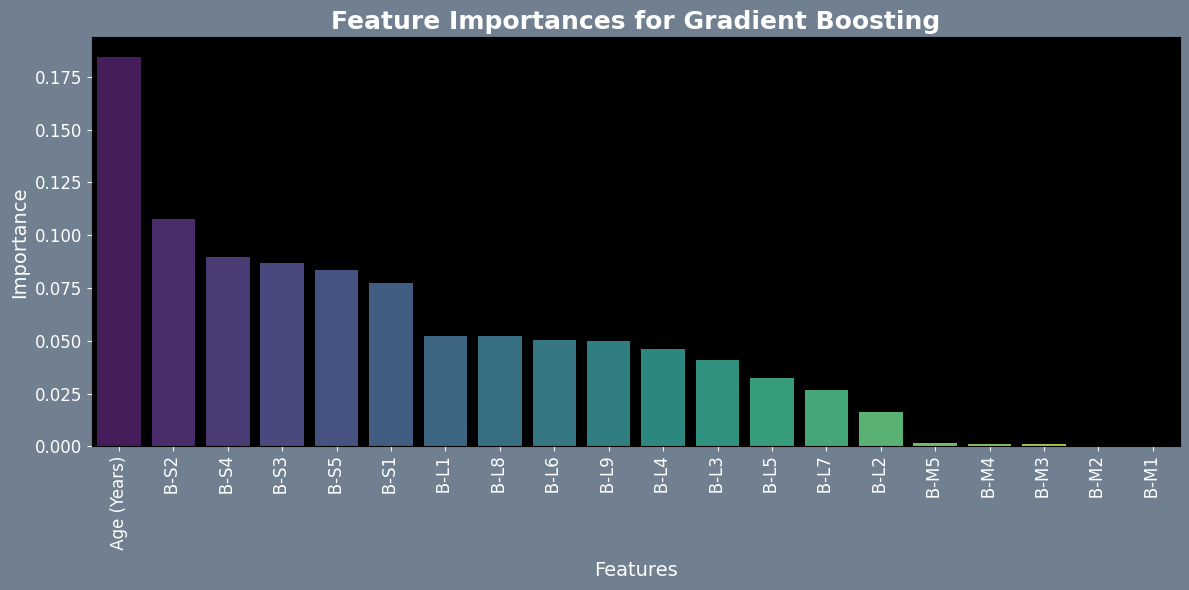

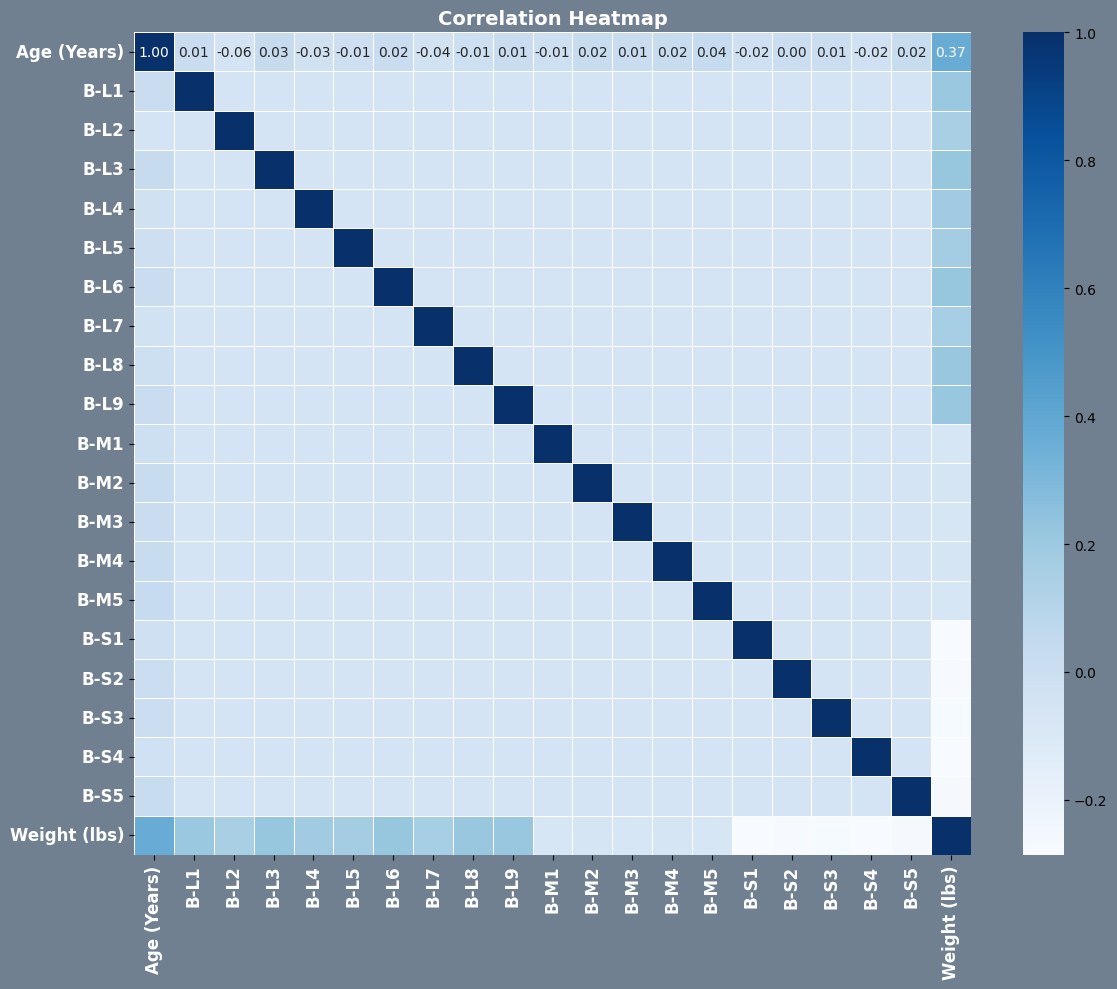

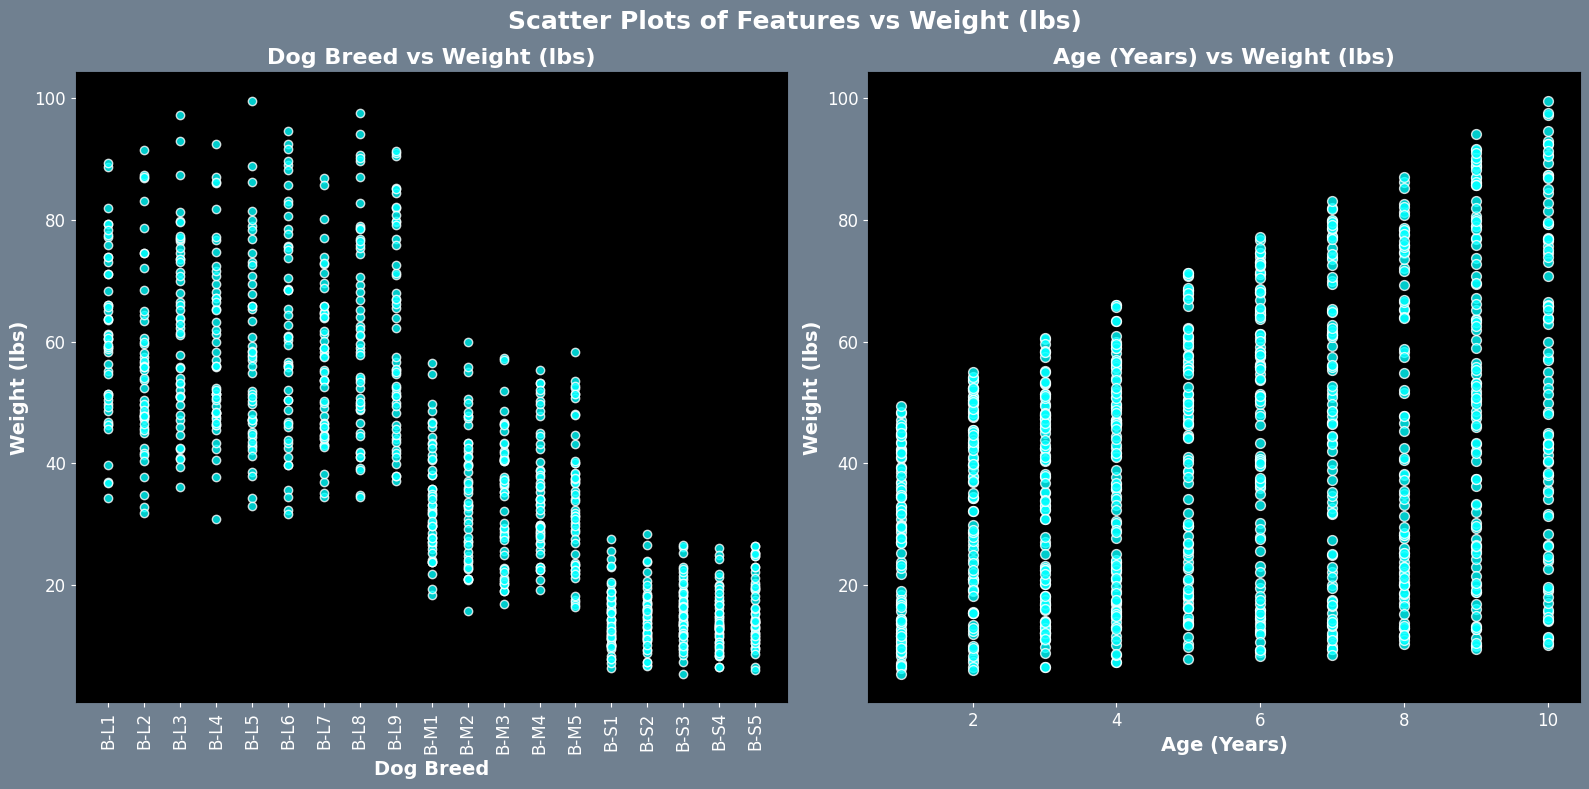

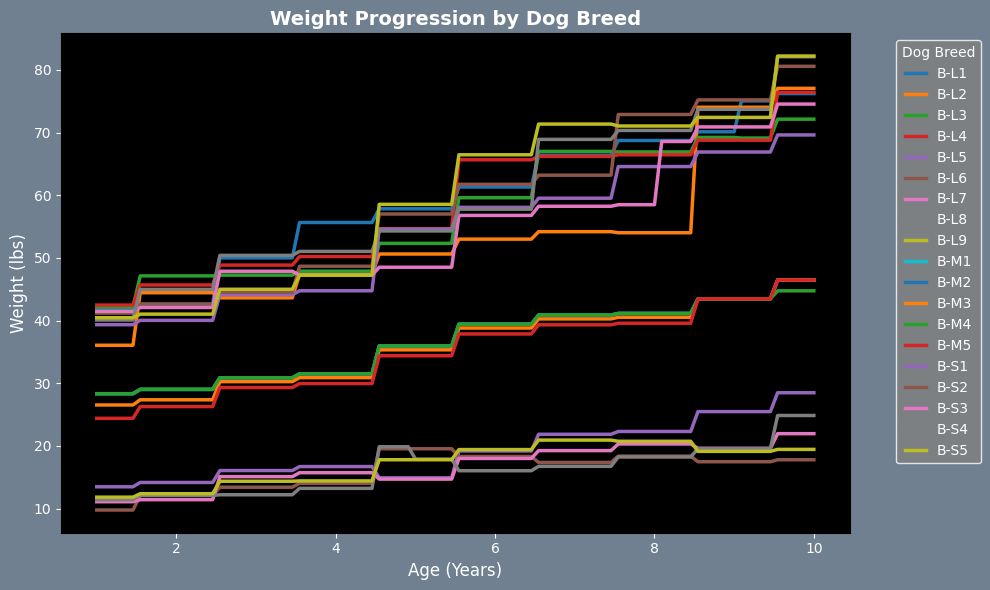

In [1]:
# Author: Uma Rao
# Class: ML 4375
# Project: Year-End Project
# This script evaluates various regression models to predict the weight of different dog breeds
# based on features like breed and age. The project aims to identify the model that best predicts
# dog weights and understand the features influencing weight variations among different breeds.
#
# Observations:
# - Models are assessed using metrics like R2, MSE, and EVS to identify the best performer.
# - Visualizations like scatter plots and correlation heatmaps provide insights into the data and model performance.
# - Feature importance is analyzed to understand the contribution of each feature to the model's predictions.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')




class DogWeightRegressionEvaluator:
    # Constructor to initialize the class with data file path
    def __init__(self, filepath):        
        self.df = pd.read_csv(filepath)
        self.models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=12),
            'Gradient Boosting': GradientBoostingRegressor(random_state=12),
            'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=12),
        }
        self.features = ['Dog Breed', 'Age (Years)']
        self.target = 'Weight (lbs)'
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), ['Age (Years)']),
                ('cat', OneHotEncoder(), ['Dog Breed'])
            ], remainder='passthrough')
        
        self.best_model_name = None
        self.results = {}
        self.scores = []  # To store scores for visualization
        self.print_title()
    
    # Displays a title on initialization
    def print_title(self):
        # Define the title text
        title_text = "D O G   W E I G H T   E V A L U A T I O N S  -  R E G R E S S I O N   M O D E L S"

        # Create a figure and axis to show the text
        fig, ax = plt.subplots()
        ax.axis('off')  # Turn off the axis

        # Place text in the middle of the figure
        ax.text(0.5, 0.5, title_text, fontsize=26, ha='center', va='center', fontweight='bold', color='blue')

        # Display the figure
        plt.show()

    # Prepares the data by splitting into train and test sets
    def prepare_data(self):
        X = self.df[self.features]
        y = self.df[self.target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
        return X_train, X_test, y_train, y_test

    # Trains models and evaluates them, choosing the best one based on a composite score
    def train_and_evaluate(self):
        
        X_train, X_test, y_train, y_test = self.prepare_data()
        composite_best_score = float('-inf')  # Inverting logic for composite score
        best_model = None

        for name, model in self.models.items():
            pipeline = Pipeline(steps=[('preprocessor', self.preprocessor), ('model', model)])
            pipeline.fit(X_train, y_train)
            preds = pipeline.predict(X_test)
            
            r2 = round(r2_score(y_test, preds), 2)
            evs = round(explained_variance_score(y_test, preds), 2)
            mse = round(mean_squared_error(y_test, preds), 2)
            mae = round(mean_absolute_error(y_test, preds), 2)


            # Composite score calculation with rounding
            composite_score = round(r2 + evs, 2)
            
            self.results[name] = {'MSE': mse, 'R2': r2, 'MAE': mae, 'EVS': evs}
            composite_score = r2 + evs
            self.scores.append([name, r2, evs, mse, mae, composite_score])
            
            if composite_score > composite_best_score:
                composite_best_score = composite_score
                best_model = pipeline
                self.best_model_name = name

        self.best_model = best_model
        print(f"The recommended model based on the composite score is: \033[1m{self.best_model_name}\033[0m")
        self.visualize_scores()  # Call to visualize the scores

    # Visualizes model scores in a table format    
    def visualize_scores(self):
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
        ax.axis('tight')
        ax.axis('off')
        table_data = [["Model", "MSE", "R2", "MAE", "EVS", "Best Score"]] + self.scores
        table = ax.table(cellText=table_data, colLabels=table_data.pop(0), loc='center', cellLoc='center')

        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.0, 1.0)

        # Convert model keys to a list for indexing
        model_keys = list(self.models.keys())

        # Styling the table
        for (i, j), cell in table.get_celld().items():
            if i == 0:
                cell.set_facecolor('slategrey')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('black')
                cell.set_text_props(color='white')
            if i > 0 and model_keys[i - 1] == self.best_model_name:  # Adjusted index check
                cell.set_facecolor('lime')
                cell.set_text_props(weight='bold')

        plt.show()

        
    # Visualizes the performance comparisons of all models using bar plots for each metric    
    def visualize_comparisons(self):
        metrics = pd.DataFrame.from_dict({
            model: {
                'MSE': res['MSE'],
                'R2': res['R2'],
                'MAE': res['MAE'],
                'EVS': res['EVS']
            } for model, res in self.results.items()
        }, orient='index')

        fig, axs = plt.subplots(2, 2, figsize=(16, 18))
        plt.gcf().set_facecolor('slategrey')  # Set the general figure background to slate grey

        # Setup for vivid and large labels
        label_size = 18  # Larger size for better readability
        label_color = 'lime'  # Vivid color for visibility

        # Plotting each metric with vivid colors and set each subplot background to black
        for i, ax in enumerate(axs.flat):
            if i == 0:
                metric = 'R2'
                palette = 'magma'
                title = 'Comparison of R2 Across Models'
            elif i == 1:
                metric = 'EVS'
                palette = 'plasma'
                title = 'Comparison of Explained Variance Score Across Models'
            elif i == 2:
                metric = 'MSE'
                palette = 'viridis'
                title = 'Comparison of MSE Across Models'
            else:
                metric = 'MAE'
                palette = 'cividis'
                title = 'Comparison of MAE Across Models'

            sns.barplot(data=metrics, x=metrics.index, y=metric, ax=ax, palette=palette)
            ax.set_title(title, fontsize=16, fontweight='bold', color='white')
            ax.set_xlabel('Models', fontsize=label_size, color=label_color)
            ax.set_ylabel(metric, fontsize=label_size, color=label_color)
            ax.set_facecolor('black')  # Set the subplot background to black
            ax.tick_params(colors='white', labelsize=14)  # Set tick parameters to be white for visibility

        plt.tight_layout()
        plt.show()


    # Plot feature importance or coefficients depending on the best model
    def plot_feature_importance(self):
        if hasattr(self.best_model.named_steps['model'], 'feature_importances_'):
            importances = self.best_model.named_steps['model'].feature_importances_
            feature_names = self.preprocessor.get_feature_names_out()
            model_type = 'Feature Importances'
        elif hasattr(self.best_model.named_steps['model'], 'coef_'):
            importances = self.best_model.named_steps['model'].coef_
            feature_names = self.preprocessor.get_feature_names_out()
            model_type = 'Coefficients'
            # Flatten the coefficients if necessary
            if importances.ndim > 1:
                importances = importances.flatten()
        else:
            raise ValueError(f"The {self.best_model_name} model does not support feature importance or coefficient extraction.")

        # Create a DataFrame with feature names and importances or coefficients
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })

        # Remove 'cat_', 'num_', 'Dog_breed_', 'Dog Breed ' from feature names
        importance_df['Feature'] = (importance_df['Feature']
                                    .str.replace('cat_', '')
                                    .str.replace('num_', '')
                                    .str.replace('Dog_breed_', '')
                                    .str.replace('Dog', '')
                                    .str.replace('Breed', '')
                                    .str.replace('Dog Breed ', '')  # Ensure this exact phrase is targeted
                                    .str.replace('_', ' '))  # Replacing underscores with spaces for better readability

        # Sort by importance
        importance_df = importance_df.sort_values('Importance', ascending=False)

        #print(f"{model_type} during Training:")
        #print(importance_df)

        # Visualization
        plt.figure(figsize=(12, 6))
        plt.gca().set_facecolor('black')  # Dark background for the axes
        plt.gcf().set_facecolor('slategrey')  # Dark background for the figure

        bars = sns.barplot(x='Feature', y='Importance', data=importance_df, palette='viridis')
        bars.set_title(f'{model_type} for {self.best_model_name}', fontsize=18, fontweight='bold', color='white')
        bars.set_xlabel('Features', fontsize=14, color='white')
        bars.set_ylabel('Importance', fontsize=14, color='white')
        bars.tick_params(axis='x', colors='white', rotation=90, labelsize=12)
        bars.tick_params(axis='y', colors='white', labelsize=12)

        plt.tight_layout()
        plt.show()

        
    # Creates scatter plots for each feature against the target variable
    def plot_feature_scatter(self):

        # Create scatter plots for each feature
        fig, axes = plt.subplots(1, len(self.features), figsize=(16, 8))
        fig.patch.set_facecolor('slategray')  # Set the background color of the figure to "smokegray"

        for i, feature in enumerate(self.features):
            if feature == 'Dog Breed':
                # Convert categorical data into numeric codes for scatter plot
                category_codes = pd.Categorical(self.df[feature]).codes
                scatter = axes[i].scatter(category_codes, self.df[self.target], alpha=0.8, c='cyan', edgecolors='w')
                axes[i].set_xticks(range(len(pd.Categorical(self.df[feature]).categories)))
                axes[i].set_xticklabels(pd.Categorical(self.df[feature]).categories, rotation=90, color='white')
            else:
                # Compute the histogram
                xbins = np.linspace(self.df[feature].min(), self.df[feature].max(), 41)
                ybins = np.linspace(self.df[self.target].min(), self.df[self.target].max(), 41)
                density, _, _ = np.histogram2d(self.df[feature], self.df[self.target], bins=[xbins, ybins])

                # Map the data points to their nearest bin center
                xidx = np.digitize(self.df[feature], xbins) - 1
                yidx = np.digitize(self.df[self.target], ybins) - 1

                # Check if xidx and yidx are within the bounds of the density array
                valid_indices = (xidx >= 0) & (xidx < density.shape[0]) & (yidx >= 0) & (yidx < density.shape[1])
                colors = np.zeros_like(xidx)
                colors[valid_indices] = density[xidx[valid_indices], yidx[valid_indices]]

                # Use a blue colormap with varying shades for the scatter plot
                scatter = axes[i].scatter(self.df[feature], self.df[self.target], c='cyan', cmap='Blues', edgecolor='w', alpha=0.8, s=50)

            axes[i].set_facecolor('black')  # Set the background color of each subplot to black
            axes[i].set_xlabel(feature, fontsize=14, color='white', fontweight='bold')
            axes[i].set_ylabel('Weight (lbs)', fontsize=14, color='white', fontweight='bold')
            axes[i].tick_params(colors='white', which='both', labelsize=12)  # Change the color and size of the ticks
            axes[i].set_title(f'{feature} vs Weight (lbs)', fontsize=16, color='white', fontweight='bold')

        plt.suptitle('Scatter Plots of Features vs Weight (lbs)', fontsize=18, fontweight='bold', color='white')
        plt.tight_layout()
        plt.show()


    # Plots the progression of weight as a function of age for each breed
    def plot_weight_progression(self):
        ages = np.linspace(self.df['Age (Years)'].min(), self.df['Age (Years)'].max(), 100)
        breeds = self.df['Dog Breed'].unique()
        plt.figure(figsize=(10, 6))

        plt.gca().set_facecolor('black')
        plt.gcf().set_facecolor('slategrey')

        cmap = plt.get_cmap('tab10')
        num_breeds = len(breeds)

        for i, breed in enumerate(breeds):
            breed_ages_df = pd.DataFrame({'Dog Breed': [breed] * len(ages), 'Age (Years)': ages})
            weight_preds = self.best_model.predict(breed_ages_df)
            plt.plot(ages, weight_preds, label=breed, color=cmap(i % 10), linewidth=2.5)

        plt.title('Weight Progression by Dog Breed', fontsize=14, fontweight='bold', color='white')
        plt.xlabel('Age (Years)', fontsize=12, color='white')
        plt.ylabel('Weight (lbs)', fontsize=12, color='white')
        plt.tick_params(axis='both', colors='white')

        legend = plt.legend(title='Dog Breed', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor='grey', edgecolor='white', handlelength=1.5)
        plt.setp(legend.get_title(), color='white')  # Manually set the legend title color
        plt.setp(legend.get_texts(), color='white')  # Set legend text color to white

        plt.grid(False)
        plt.tight_layout()
        plt.show()


    # Plots a heatmap to visualize the correlation among all features and the target
    def plot_correlation_heatmap(self):
        # Adjust the ColumnTransformer to output a dense matrix
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), ['Age (Years)']),
                ('cat', OneHotEncoder(), ['Dog Breed'])
            ], remainder='passthrough', sparse_threshold=0)

        # Fit and transform the features
        X_transformed = self.preprocessor.fit_transform(self.df[self.features])

        # Get the feature names from the ColumnTransformer and clean them
        feature_names = self.preprocessor.get_feature_names_out()
        clean_feature_names = [name.replace('cat__', '').replace('num__', '').replace('_', ' ').replace('Dog Breed ', '') for name in feature_names]

        # Convert the numpy array to a DataFrame with appropriate column names
        X_transformed_df = pd.DataFrame(X_transformed, columns=clean_feature_names)

        # Concatenate with the target variable to create a full DataFrame
        full_df = pd.concat([X_transformed_df, self.df[self.target].reset_index(drop=True)], axis=1)

        # Calculate the correlation matrix
        corr_matrix = full_df.corr()

        # Plot the correlation heatmap with aesthetic enhancements
        plt.figure(figsize=(12, 10))
        plt.gca().set_facecolor('black')  # Dark background for the axes
        plt.gcf().set_facecolor('slategrey')  # Dark background for the figure
        sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", linecolor='white', linewidths=0.5)
        plt.title('Correlation Heatmap', fontsize=14, fontweight='bold', color='white')
        plt.xticks(fontsize=12, fontweight='bold', color='white', rotation=90)
        plt.yticks(fontsize=12, fontweight='bold', color='white', rotation=0)
        plt.tight_layout()
        plt.show()



####################################
# M A I N   M E T H O D
####################################
def main():
    filepath = 'synthetic_dog_data.csv'  # Update with the actual path to your dataset
    evaluator = DogWeightRegressionEvaluator(filepath)
    evaluator.train_and_evaluate()
    evaluator.visualize_comparisons()
    evaluator.plot_feature_importance()
    evaluator.plot_correlation_heatmap()
    evaluator.plot_feature_scatter()
    evaluator.plot_weight_progression()

if __name__ == "__main__":
    main()
